In [31]:
import numpy as np
import pandas as pd
import rdata
import matplotlib.pyplot as plt

import correlation_correction.methods.hamling_methods as ham
import correlation_correction.methods.gl_methods as gl
import correlation_correction.regressions as reg

In [67]:
parsed = rdata.parser.parse_file("/Volumes/mnt/team/team/pub/sub_risks/tobacco/code/xdai88/gbd2020_smoking/relative_risk_curves/cleaned_all_data/00_prepped_data/asthma.RDS")
converted = rdata.conversion.convert(parsed)
df = converted["df"]

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/rdata/parser/_parser.py:1217: UserWarning: Unknown file type: assumed RDS
  warnings.warn("Unknown file type: assumed RDS")  # noqa: B028
/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/rdata/parser/_parser.py:1220: UserWarning: Wrong extension .RDS for file in RDS format
  warnings.warn(f"Wrong extension {extension} for file in RDS format")  # noqa: B028


In [68]:
flat_df = df[df["nid"] == 346743]
reindex_list = [27,26,25]
flat_df = flat_df.reindex(reindex_list)
flat_df

,nid,ln_effect,ln_se,b_0,b_1,a_0,a_1,percent_male,age_start,age_end,age_ref,cv_adj_L0,cv_adj_L1,cv_adj_L2,cv_exposure_study
27,346743,-0.223144,0.159439,1.0,14.0,0,0,0.0,30,55,15,1,1,0,1
26,346743,-0.248461,0.160256,26.0,39.0,0,0,0.0,30,55,15,1,1,0,1
25,346743,-0.371064,0.140491,15.0,24.0,0,0,0.0,30,55,15,1,1,0,1


We're defining our data here. I think $$b_0 = 321304$$ and $$a_0 = 329$$ because they do references as never-smokers. I'm not sure, but I can talk to Sasha about this.

In [69]:
# np.random.seed(123)
# ratio_num = np.random.uniform(1,8)
x = np.array([(1+14)/2, (15+24)/2, (26+39)/2])
L = flat_df[flat_df["nid"] == 346743]["ln_effect"].to_numpy()
v = (flat_df[flat_df["nid"] == 346743]["ln_se"].to_numpy())**2
z = (174504 + 321304) / (103 + 329)
p = 321304 / (174504 + 321304)

N = np.array([321304, 174504/3, 174504/3, 174504/3])
M1 = 329 + 103

In [70]:
ham.hamling(L,p,z,v,OR=False)

(array([30.86757147, 30.8347298 , 43.37059471]),
 array([105.60915775, 108.20184051, 172.04235958]),
 254.55786643061555,
 696.7478319405238)

In [71]:
gl.convex_gl(L,N,M1,OR=False)

(array([44.35277014, 43.24276129, 38.24956642]),
 array([58168., 58168., 58168.]),
 306.15490215236093,
 321304.0)

In [72]:
C_ham = reg.covariance_matrix_hamling(L,p,z,v,OR=False)
C_gl = reg.covariance_matrix_convex_gl(L,N,M1,v,OR=False)

In [73]:
bstar_ham, vstar_ham = reg.gls_reg(C_ham,L,x)
bstar_gl, vstar_gl = reg.gls_reg(C_gl,L,x)

In [74]:
b, v_reg = reg.wls_reg(L,x,v)

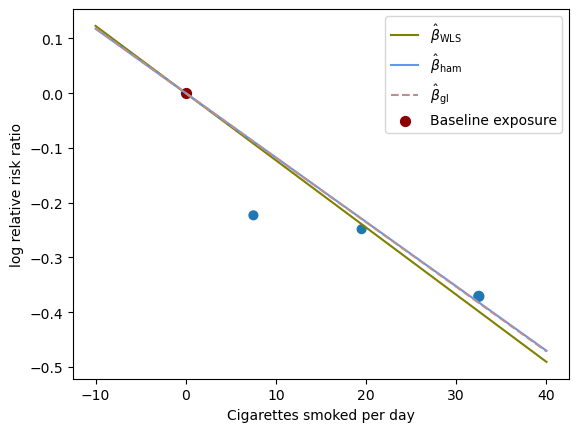

In [83]:
def slope_fn(beta,x):
    return beta*x

x_pts = np.linspace(-10,40)

# plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
# plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
# plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
# plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x_pts,slope_fn(b,x_pts),label=r"$\hat \beta_{\mathrm{WLS}}$",c="olive")
plt.plot(x_pts,slope_fn(bstar_ham,x_pts),label=r"$\hat \beta_{\mathrm{ham}}$",c="cornflowerblue")
plt.plot(x_pts,slope_fn(bstar_gl,x_pts),label=r"$\hat \beta_{\mathrm{gl}}$",c="rosybrown",linestyle="dashed")
# plt.plot(x,slope_fn(bstar,x)-0.063,label="Intercept",linestyle="dashed",c="cornflowerblue")
plt.scatter(x,L,s = 1/v)

plt.scatter(0,0,c="darkred",s=50,label="Baseline exposure")
plt.ylabel("log relative risk ratio")
plt.xlabel("Cigarettes smoked per day")
plt.legend()
# plt.savefig("images/itoga_regression.pdf",bbox_inches="tight",pad_inches=0.1)
plt.show()

In [84]:
v

array([0.02542072, 0.02568212, 0.01973772])

In [76]:
bstar_gl

-0.011787684721382058

In [77]:
b

-0.012270537350315344

In [78]:
bstar_ham

-0.011760431489251362

In [79]:
vstar_gl

1.5958804316706667e-05

In [80]:
vstar_ham

1.614039368551281e-05

In [82]:
v_reg

1.4177743996667474e-05